# DATA CLEANING

In [52]:
import pandas as pd

# Load the dataset to examine the structure and identify any missing values or duplicates
sales_data = pd.read_csv('sales_data.csv')

# Display the first few rows of the dataset and get basic info
sales_data_head = sales_data.head()
sales_data_info = sales_data.info()
missing_values = sales_data.isnull().sum()
duplicates = sales_data.duplicated().sum()

sales_data_head, sales_data_info, missing_values, duplicates


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Customer ID   363 non-null    object 
 1   Order ID      363 non-null    object 
 2   Order Date    363 non-null    object 
 3   Product ID    363 non-null    object 
 4   Product Name  363 non-null    object 
 5   Category      363 non-null    object 
 6   Quantity      363 non-null    int64  
 7   Unit Price    363 non-null    float64
 8   Region        363 non-null    object 
 9   Total Amount  363 non-null    float64
dtypes: float64(2), int64(1), object(7)
memory usage: 28.5+ KB


(                            Customer ID                              Order ID  \
 0  8a80ddb1-8615-4452-adce-db56c9385365  d929f0c8-5600-456b-9360-ae114e339871   
 1  ac664d43-893a-47a1-bdd7-139f73a360a7  38d57142-b1f3-4b25-ae2e-e7404d2df736   
 2  ebbc4ba3-d24f-4e25-a585-15c8e6bacbd7  58a7f2a2-5682-4510-b94e-cb56d076880d   
 3  5f3f88e8-b638-4cfd-9af8-e14b63d9082f  12af190c-f3a3-4209-b7a7-fa7a66337df8   
 4  2029cf6c-dd8e-430c-ae24-586d3a5f422a  d283a232-0b04-49e9-bad3-6dcfd115b421   
 
    Order Date                            Product ID Product Name     Category  \
 0  2021-12-25  9c485900-229d-4b96-ac99-374754d40e1c      T-shirt  Accessories   
 1  2022-10-08  3ff68652-ba71-4610-9284-71f778fd2819   Smartphone     Clothing   
 2  2022-11-30  99ad1f2f-fa2e-4b27-8952-7b23249eeebc      T-shirt        Books   
 3  2023-02-12  b767b606-a5c1-46fc-83fa-78de163b8fce        Watch     Clothing   
 4  2023-02-17  15baeab4-63b9-4b98-a52f-40697bcd0c0f        Watch  Accessories   
 
    Quantity

# Customer Segmentation (RFM Analysis)

In [53]:
# Standardize the date format in the 'Order Date' column
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'], format='%Y-%m-%d')

# Confirm the change by checking the data type of the 'Order Date' column
sales_data.dtypes['Order Date']


dtype('<M8[ns]')

In [54]:
# Calculate Recency, Frequency, and Monetary value for each customer

# Current date to calculate Recency (assuming the last date in the dataset as a reference point)
current_date = sales_data['Order Date'].max()

# RFM calculations
rfm_data = sales_data.groupby('Customer ID').agg({
    'Order Date': lambda x: (current_date - x.max()).days,  # Recency
    'Order ID': 'count',  # Frequency
    'Total Amount': 'sum'  # Monetary
}).reset_index()

# Rename the columns for clarity
rfm_data.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Display the first few rows of the RFM data
rfm_data.head()


,Customer ID,Recency,Frequency,Monetary
0,005612ec-5aea-48d6-9a6d-cdf0f538f4da,442,1,720.52
1,01329251-44d2-4ed4-b3cb-0d6b13a4712f,184,1,3356.50
2,015cda0c-7c05-45ab-8438-ac338a7db94c,511,1,1641.24
3,018c6e2c-9c84-45e1-991b-9310c5e174a5,254,1,2746.70
4,02167aaa-8387-4e7e-b1fe-30c87b9a52ed,386,1,2010.51


In [55]:
# Define thresholds for segmentation (these can be adjusted based on data distribution)
# Segment based on quantiles for simplicity

quantiles = rfm_data.quantile(q=[0.25, 0.5, 0.75]).to_dict()

# Functions to segment customers based on RFM metrics
def r_score(x):
    if x <= quantiles['Recency'][0.25]:
        return 'High-Value'
    elif x <= quantiles['Recency'][0.5]:
        return 'Medium-Value'
    elif x <= quantiles['Recency'][0.75]:
        return 'Low-Value'
    else:
        return 'At-Risk'

def fm_score(x, metric):
    if x <= quantiles[metric][0.25]:
        return 'Low'
    elif x <= quantiles[metric][0.5]:
        return 'Medium'
    elif x <= quantiles[metric][0.75]:
        return 'High'
    else:
        return 'Very High'

# Apply the segmentation functions
rfm_data['Recency_Segment'] = rfm_data['Recency'].apply(r_score)
rfm_data['Frequency_Segment'] = rfm_data['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm_data['Monetary_Segment'] = rfm_data['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

# Combine segments into final customer segments
rfm_data['Customer_Segment'] = rfm_data.apply(lambda row: f"R{row['Recency_Segment']}-F{row['Frequency_Segment']}-M{row['Monetary_Segment']}", axis=1)

# Display the first few rows of the segmented data
rfm_data.head(10)


,Customer ID,Recency,Frequency,Monetary,Recency_Segment,Frequency_Segment,Monetary_Segment,Customer_Segment
0,005612ec-5aea-48d6-9a6d-cdf0f538f4da,442,1,720.52,Low-Value,Low,Medium,RLow-Value-FLow-MMedium
1,01329251-44d2-4ed4-b3cb-0d6b13a4712f,184,1,3356.50,High-Value,Low,Very High,RHigh-Value-FLow-MVery High
2,015cda0c-7c05-45ab-8438-ac338a7db94c,511,1,1641.24,Low-Value,Low,High,RLow-Value-FLow-MHigh
3,018c6e2c-9c84-45e1-991b-9310c5e174a5,254,1,2746.70,Medium-Value,Low,Very High,RMedium-Value-FLow-MVery High
4,02167aaa-8387-4e7e-b1fe-30c87b9a52ed,386,1,2010.51,Low-Value,Low,High,RLow-Value-FLow-MHigh
5,02406387-ff72-4721-93d8-f102e869c4b7,725,1,859.60,At-Risk,Low,Medium,RAt-Risk-FLow-MMedium
6,03693cb7-c0c4-4d76-9b8e-4326b964e2b6,645,1,3061.52,At-Risk,Low,Very High,RAt-Risk-FLow-MVery High
7,03e71c3f-6f5e-441b-971d-000721a0651d,366,1,196.39,Low-Value,Low,Low,RLow-Value-FLow-MLow
8,048dcc59-2b7a-4edb-8d7b-1b847411b658,458,1,3116.00,Low-Value,Low,Very High,RLow-Value-FLow-MVery High
9,04e780a1-dcff-4fc5-8f2a-7ed055f27220,600,1,2180.56,At-Risk,Low,Very High,RAt-Risk-FLow-MVery High


In [56]:
import pandas as pd

# Assuming 'rfm_data' is your dataframe after RFM calculation and segmentation

# Total number of customers
total_customers = len(rfm_data)

# Calculate the percentage of High-Value Customers
high_value_customers = len(rfm_data[rfm_data['Recency_Segment'] == 'High-Value'])
x_percent = (high_value_customers / total_customers) * 100

# Calculate total revenue (sum of 'Monetary' values)
total_revenue = rfm_data['Monetary'].sum()

# Calculate the revenue contribution of High-Value Customers
high_value_revenue = rfm_data[rfm_data['Recency_Segment'] == 'High-Value']['Monetary'].sum()
y_percent = (high_value_revenue / total_revenue) * 100

# Calculate the percentage of At-Risk Customers
at_risk_customers = len(rfm_data[rfm_data['Recency_Segment'] == 'At-Risk'])
z_percent = (at_risk_customers / total_customers) * 100

# Display the results
print(f"X% of the customers are High-Value Customers: {x_percent:.2f}%")
print(f"Y% of the total revenue comes from High-Value Customers: {y_percent:.2f}%")
print(f"Z% of the customers are At-Risk: {z_percent:.2f}%")


X% of the customers are High-Value Customers: 25.07%
Y% of the total revenue comes from High-Value Customers: 22.62%
Z% of the customers are At-Risk: 25.07%


# Sales Trend Analysis

In [64]:
# Extract Year and Month from 'Order Date' for trend analysis
sales_data['Year'] = sales_data['Order Date'].dt.year
sales_data['Month'] = sales_data['Order Date'].dt.month

# Aggregate total sales by year and month
monthly_sales_trend = sales_data.groupby(['Year', 'Month'])['Total Amount'].sum().reset_index()

# Best-performing product categories by total sales
category_sales = sales_data.groupby('Category')['Total Amount'].sum().reset_index().sort_values(by='Total Amount', ascending=False)

# Regional sales analysis
regional_sales = sales_data.groupby('Region')['Total Amount'].sum().reset_index().sort_values(by='Total Amount', ascending=False)

# Display the results
monthly_sales_trend.head(), category_sales.head(), regional_sales.head()


(   Year  Month  Total Amount
 0  2021      8      17021.38
 1  2021      9      19482.53
 2  2021     10      24312.71
 3  2021     11      28496.76
 4  2021     12      15959.63,
          Category  Total Amount
 1           Books     115120.41
 3     Electronics     101544.99
 2        Clothing      94677.73
 4  Home & Kitchen      92568.42
 0     Accessories      87386.95,
   Region  Total Amount
 0   East     140332.35
 2  South     128528.63
 1  North     116418.31
 3   West     106019.21)

# Data Visualization

# Line Chart for Sales Over Time:

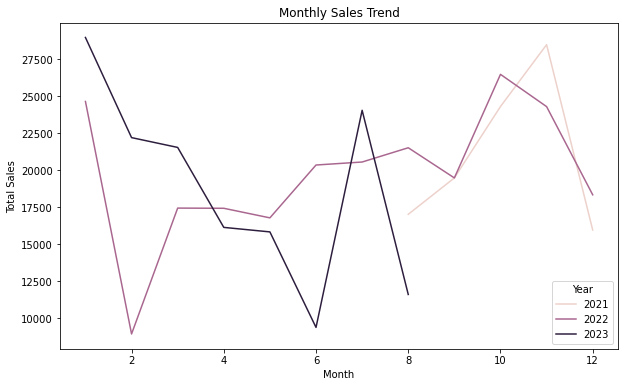

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line chart for monthly sales trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales_trend, x='Month', y='Total Amount', hue='Year')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

# Bar Chart for Top Product Categories:

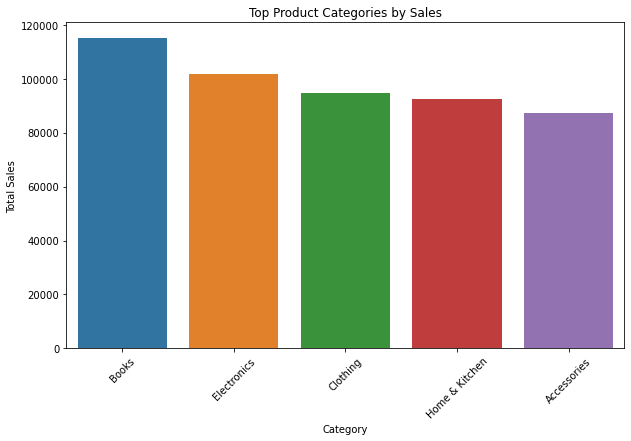

In [65]:
# Bar chart for best-performing product categories
plt.figure(figsize=(10, 6))
sns.barplot(data=category_sales, x='Category', y='Total Amount')
plt.title('Top Product Categories by Sales')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


# Pie Chart for Regional Sales Distribution:

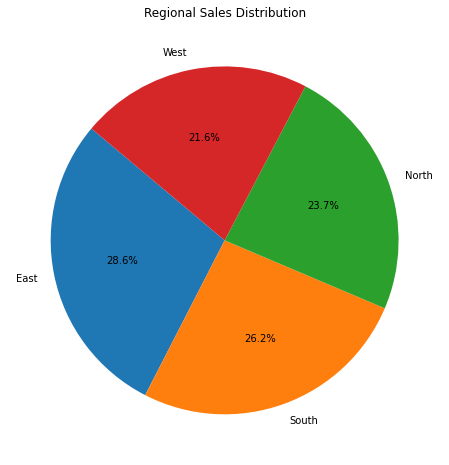

In [61]:
# Pie chart for regional sales distribution
plt.figure(figsize=(8, 8))
plt.pie(regional_sales['Total Amount'], labels=regional_sales['Region'], autopct='%1.1f%%', startangle=140)
plt.title('Regional Sales Distribution')
plt.show()

# Let's calculate the exact percentages from the dataset for:
- Peak sales month: A%
- Lowest sales month: B%
- Top-performing category: C%
- Lowest-performing category: D%

In [69]:
# Convert 'Order Date' to datetime format
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])

# Extract year and month for grouping
sales_data['Year'] = sales_data['Order Date'].dt.year
sales_data['Month'] = sales_data['Order Date'].dt.month

# Group data by month and calculate the total sales
monthly_sales = sales_data.groupby('Month')['Total Amount'].sum()

# Calculate the percentage contribution of each month to the total yearly sales
total_yearly_sales = monthly_sales.sum()
monthly_sales_percentage = (monthly_sales / total_yearly_sales) * 100

# Get A% and B%
A_percent = monthly_sales_percentage.max()  # Peak sales percentage
B_percent = monthly_sales_percentage.min()  # Lowest sales percentage

# Group data by category and calculate the total sales
category_sales = sales_data.groupby('Category')['Total Amount'].sum()

# Calculate the percentage contribution of each category to the total sales
total_sales = category_sales.sum()
category_sales_percentage = (category_sales / total_sales) * 100

# Get C% and D%
C_percent = category_sales_percentage.max()  # Top-performing category percentage
D_percent = category_sales_percentage.min()  # Lowest-performing category percentage

print(f'Peak sales',A_percent,'\nLowest sales', B_percent,'\nTop-performing category', C_percent,'\nLowest-performing category', D_percent)


Peak sales 10.918272699794523 
Lowest sales 6.0504947603137404 
Top-performing category 23.431866777529347 
Lowest-performing category 17.786936048044115
